# Shishkin mesh

This notebook demonstrates some functions that create a stepwise-refined mesh, sometimes called a Shsikin mesh

The functions allow you to set target maximum coarsening and minumum refinement, then they automatically adjust the coarse / fine element division.

New coordinates are provided as a dictionary, which is a good approach for running parallel, rather than trying to automatically modify mesh coordinates

In [1]:
import underworld as uw
import math
from underworld import function as fn
import glucifer
import numpy as np
import collections


In [2]:
##########
#Model setup parameters
###########

stickyAir = False

MINX = -1.
MINY = 0.
MAXX = 1.0

#MAXY = 1.035
MAXY = 1.

if MINX == 0.:
    squareModel = True
else: 
    squareModel = False
    
    
dim = 2          # number of spatial dimensions


#MESH STUFF

RES = 192

if MINX == 0.:
    Xres = RES
else:
    Xres = 2*RES

if stickyAir:
    Yres = RES + 8
    MAXY = float(Yres)/RES
    
else:
    Yres = RES
    MAXY = 1.


periodic = [False,False]
elementType = "Q1/dQ0"
#elementType ="Q2/DPC1"

refineMesh = True

In [3]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = (Xres, Yres), 
                                 minCoord    = (MINX,MINY), 
                                 maxCoord=(MAXX,MAXY), periodic=periodic)

In [4]:
print(mesh.data.shape)

(74305, 2)


In [5]:
def coarse_fine_division(mesh, axis="y", refine_by=2., relax_by =0.5):
    if axis == "y":
        thisaxis = 1
    else:
        thisaxis = 0
    width = (mesh.maxCoord[thisaxis]-mesh.minCoord[thisaxis])
    dx = (mesh.maxCoord[thisaxis]-mesh.minCoord[thisaxis])/ (mesh.elementRes[thisaxis])
    nx = mesh.elementRes[thisaxis]
    dxf = dx/ refine_by
    dxc = dx/ relax_by
    #print("refine By:" + str(refine_by))
    i = 0
    current_width = ((nx - i)  * dxf) + (i * dxc)
    while current_width < width:
        i += 1
        current_width = ((nx - i)  * dxf) + (i * dxc)
    #print current_width
    #correct dxc so the total domain is preserved.
    dxc = (width  - ((nx - i)  * dxf))/i
    nxf = (nx - i) 
    nxc = i
    nt = (nxf + nxc)
    assert nt == nx
    return nxf, dxf, nxc, dxc



In [6]:
def shishkin_centre_arrange(mesh,  nxf, dxf, nxc, dxc, axis="y",centre = 0.5):
    """Returns dictionary that maps
    original coordinates to new coordinaters.
    
    nxf: number of fine elements
    dxf: size of fine elements
    nxc: number or coarse elements
    dxc: size of coarse elements 
    """
    import itertools
    if axis == "y":
        thisaxis = 1
    else:
        thisaxis = 0
    #print thisaxis
    ###################
    #Get the number of coarse elements either side of fine elements
    ###################
    nr = nxc
    nl = 0
    #print((nxf*dxf - abs(mesh.minCoord[thisaxis])))
    if ((nxf*dxf - abs(mesh.minCoord[thisaxis])) > centre):
        print("left edge")
        pass
    else:
        left_length = (nl*dxc) + 0.5*(dxf*nxf) - abs(mesh.minCoord[thisaxis])
        while (left_length <  centre):
            nl += 1
            left_length = (nl*dxc) + 0.5*(dxf*nxf) - abs(mesh.minCoord[thisaxis])
            #print(left_length)
            if nl == nxc:
                print("right edge")
                break
        nr = nxc - nl
    #print(nl, nr, nxf)
    #assert nr + nl + nxf == mesh.elementRes[thisaxis]
    ###################
    #return dictionary of new element mappings
    ###################
    lcoords = [(mesh.minCoord[thisaxis] + i*dxc) for i in range(nl+1)]
    if lcoords:
        #print(nl, lcoords[-1]/dxc)
        ccoords =  [lcoords[-1] + i*dxf for i in range(1, nxf+1)]
    else:
        ccoords =  [(mesh.minCoord[thisaxis] + i*dxf) for i in range(0, nxf)]
    rcoords = [ccoords[-1] + i*dxc for i in range(1, nr +1)]
    if rcoords:
        #rcoords.append(mesh.maxCoord[0])
        pass
    else:
        #ccoords.append(mesh.maxCoord[0])
        pass
    newcoords = lcoords+ ccoords+ rcoords
    #assert len(newcoords) == nx + 1
    #origcoords = list(np.unique(mesh.data[:,thisaxis]))
    #origcoords = np.linspace(mesh.minCoord[thisaxis], mesh.maxCoord[thisaxis], mesh.elementRes[thisaxis])
    width = (mesh.maxCoord[thisaxis]-mesh.minCoord[thisaxis])
    dx = (mesh.maxCoord[thisaxis]-mesh.minCoord[thisaxis])/ (mesh.elementRes[thisaxis])
    origcoords = list(np.arange(mesh.minCoord[thisaxis], mesh.maxCoord[thisaxis], dx))
    origcoords.append(mesh.maxCoord[thisaxis])
    origcoords = [round(elem, 8) for elem in origcoords]
    dictionary = dict(itertools.izip(origcoords, newcoords))
    assert len([x for x, y in collections.Counter(newcoords).items() if y > 1]) == 0 #checks agains multiple coordinates
    return dictionary


In [7]:
def shishkin_deform(mesh, centre = 0.5, axis="y", refine_by=2., relax_by =0.5):
    if axis == "y":
        thisaxis = 1
    else:
        thisaxis = 0
    print axis
    nxf, dxf, nxc, dxc, = coarse_fine_division(mesh,axis, refine_by=refine_by, relax_by =relax_by)
    coorddict = shishkin_centre_arrange(mesh, nxf=nxf, dxf=dxf, nxc=nxc, dxc=dxc, axis=axis , centre=centre)
    with mesh.deform_mesh():
        for index, coord in enumerate(mesh.data):
            key =  round(mesh.data[index][thisaxis], 8)     
            #print key
            mesh.data[index][thisaxis] = coorddict[key]

In [9]:
mesh.reset()


In [10]:
if refineMesh:
    
    shishkin_deform(mesh, centre = 0.9, axis="y", refine_by=2.0, relax_by =0.5)
    shishkin_deform(mesh, centre = 0.0, axis="x", refine_by=2.0, relax_by =0.75)

y
right edge
x



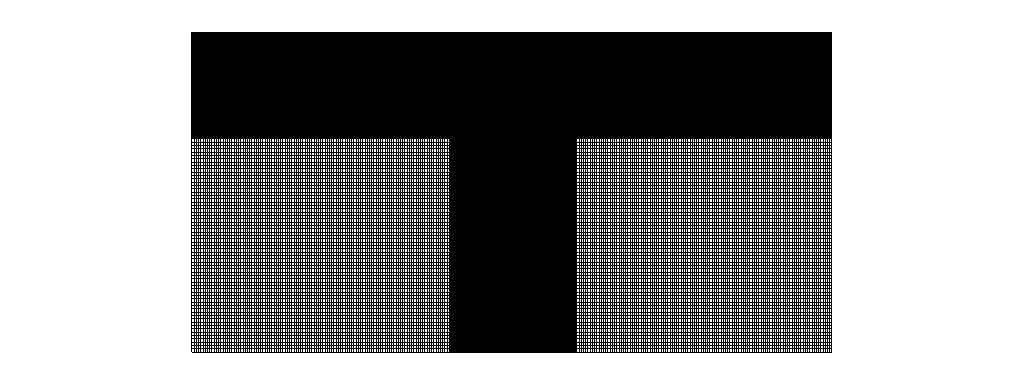

In [11]:
fig= glucifer.Figure(figsize=(1024,384))
fig.append( glucifer.objects.Mesh(mesh))
fig.save_database('test.gldb')
fig.show()

So the dictionary approach, while easier for parallel mesh refinement, is really clunky because of using potential high precision floats as dictionary keys. Key errors are likely to reappear as long a we do it like this. 



In [77]:
centre = 0.0
axis="x"
refine_by=2.0
relax_by =0.75

nxf, dxf, nxc, dxc, = coarse_fine_division(mesh,axis, refine_by=refine_by, relax_by =relax_by)
coorddict = shishkin_centre_arrange(mesh, nxf=nxf, dxf=dxf, nxc=nxc, dxc=dxc, axis=axis , centre=centre)


thisaxis = 0
dx = (mesh.maxCoord[thisaxis]-mesh.minCoord[thisaxis])/ (mesh.elementRes[thisaxis])

cdk = coorddict.keys()
cdk.sort()

origcoords = list(np.arange(mesh.minCoord[thisaxis], mesh.maxCoord[thisaxis], dx))
origcoords.append(mesh.maxCoord[thisaxis])
origcoords = [round(elem, 5) for elem in origcoords]

origcoords == cdk